# Compare REM and HAND approaches

In [44]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import py3dep
import rasterio
import rioxarray
from pynhd import NHD, prepare_nhdplus
import whitebox
from shapely import box
import xrspatial
import pysheds
import shapely

import os
import tempfile

In [10]:
aoi = box(-119.865551,34.005791,-119.785711,34.040756)

nhd = NHD('flowline_mr')

dem = py3dep.get_map("DEM", aoi, resolution=10, geo_crs=4326, crs=4326)
flow = nhd.bygeom(aoi, geo_crs=4326)

In [11]:
dem = dem.rio.reproject(3310)
flow = flow.to_crs(3310)

In [12]:
# get coordinates of start and end of each flowline
# keep only the one with the lowest elevation
def get_pour_point(flowline, dem):
    start_point = flowline.coords[0]
    end_point = flowline.coords[-1]
    elev_start_point = dem.sel(x=start_point[0], y=start_point[1], method='nearest').values.item()
    elev_end_point = dem.sel(x=end_point[0], y=end_point[1], method='nearest').values.item()

    if elev_start_point > elev_end_point:
        return shapely.Point(end_point)
    else:
        return shapely.Point(start_point)


In [16]:
# clip each line to the bounds and get pour points
flow['geometry'] = flow['geometry'].apply(lambda x: x.intersection(box(*dem.rio.bounds())))
pour_points = gpd.GeoSeries([get_pour_point(line, dem=dem) for line in flow['geometry']], index=flow.index)
pour_points.head(4)

0    POINT (16285.965 -442275.449)
1    POINT (13094.807 -444143.381)
2    POINT (12414.627 -443690.391)
3    POINT (18450.362 -443262.660)
dtype: geometry

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

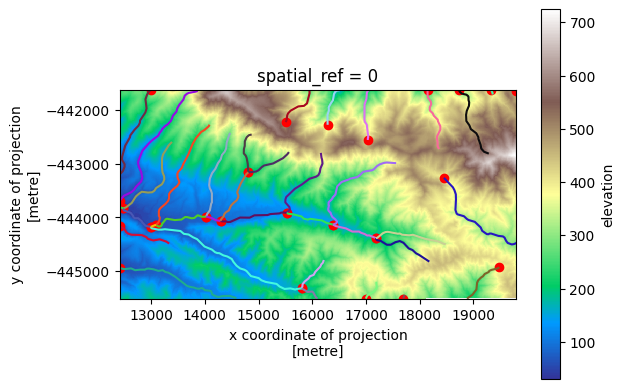

In [26]:
fig, ax = plt.subplots()
colors = [tuple(c) for c in np.random.rand(len(flow['geometry']), 3)]

dem.plot(ax=ax, cmap='terrain')
flow['geometry'].plot(ax=ax, color=colors)
pour_points.plot(ax=ax, color='red')

use whiteboxtools:
- filldepressions
- d8pointer
- rasterizeStreams
- subbasins
- hillslopes
- ElevationAboveStream

In [88]:
def wb_wrapper(wbt_method, params, return_file=False):
    
    # for each param that is raster, save to file
    for p,v in params.items():
        if hasattr(v, 'rio'):
            # write v to temp file
            # update v to be the path to that file
            temp_file = tempfile.NamedTemporaryFile(suffix=".tif")
            v.rio.to_raster(temp_file.name, driver="GTiff")
            params[p] = temp_file.name
                

    # make function call
    wbt_method(**params)

    if return_file:
        return params['output']

    raster_file_path = params['output']
    output_raster = rioxarray.open_rasterio(raster_file_path)
    os.remove(raster_file_path)
    return output_raster 

def my_callback(value):
    if not "%" in value:
        print(value)

In [72]:
wbt = whitebox.WhiteboxTools()
wbt.set_whitebox_dir("/Users/arthurkoehl/opt/WBT/")

working_directory = "/Users/arthurkoehl/programs/pasternack/valleys/"
wbt.set_working_dir(os.path.abspath(working_directory))
wbt.version()

"WhiteboxTools v2.3.0 (c) Dr. John Lindsay 2017-2023\n\nWhiteboxTools is an advanced geospatial data analysis platform developed at\nthe University of Guelph's Geomorphometry and Hydrogeomatics Research \nGroup (GHRG). See www.whiteboxgeo.com for more details.\n"

In [92]:
params = {
    "dem": dem,
    "output": os.path.join(working_directory, "filled_dem.tif"),
    "dist": 1000,
    "max_cost": None,
    "min_dist": True,
    "flat_increment": None,
    "fill": True,
    "callback": my_callback
}

filled_dem_file = wb_wrapper(wbt.breach_depressions_least_cost, params, return_file=True)
filled_dem_file

./whitebox_tools --run="BreachDepressionsLeastCost" --wd="/Users/arthurkoehl/programs/pasternack/valleys" --dem='/var/folders/l2/9h6xd6f555321vx3s_ttqb_80000gn/T/tmp3yj34z0d.tif' --output='/Users/arthurkoehl/programs/pasternack/valleys/filled_dem.tif' --dist='1000' --min_dist --fill -v --compress_rasters=False

*****************************************
* Welcome to BreachDepressionsLeastCost *
* Powered by WhiteboxTools              *
* www.whiteboxgeo.com                   *
*****************************************
Reading data...
Num. solved pits: 474
Num. unsolved pits: 0
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.26s


'/Users/arthurkoehl/programs/pasternack/valleys/filled_dem.tif'

In [93]:
# d8 pointer
params = {
    "dem": filled_dem_file, 
    "output": os.path.join(working_directory, "d8_pntr.tif"), 
    "esri_pntr": False, 
    "callback": my_callback
}
d8_pntr_file = wb_wrapper(wbt.d8_pointer, params, return_file=True)

# note that to plot this need to take into account the nodata value, e.g:
# test = rioxarray.open_rasterio(d8_pntr_file)
# test.where(test != -32578).plot()

./whitebox_tools --run="D8Pointer" --wd="/Users/arthurkoehl/programs/pasternack/valleys" --dem='/Users/arthurkoehl/programs/pasternack/valleys/filled_dem.tif' --output='/Users/arthurkoehl/programs/pasternack/valleys/d8_pntr.tif' -v --compress_rasters=False

****************************
* Welcome to D8Pointer     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.17s


In [112]:
# rasterize streams
flow.to_file(os.path.join(working_directory, 'flow.shp'))

params = {
    'streams': os.path.join(working_directory, 'flow.shp'),
    'base': d8_pntr_file,
    'output': os.path.join(working_directory, "streams.tif"), 
    'nodata': True, 
    'feature_id': True, 
    'callback': my_callback
}

stream_raster_file = wb_wrapper(wbt.rasterize_streams, params, return_file=True)

./whitebox_tools --run="RasterizeStreams" --wd="/Users/arthurkoehl/programs/pasternack/valleys" --streams='/Users/arthurkoehl/programs/pasternack/valleys/flow.shp' --base='/Users/arthurkoehl/programs/pasternack/valleys/d8_pntr.tif' --output='/Users/arthurkoehl/programs/pasternack/valleys/streams.tif' --nodata --feature_id -v --compress_rasters=False

*******************************
* Welcome to RasterizeStreams *
* Powered by WhiteboxTools    *
* www.whiteboxgeo.com         *
*******************************
Reading streams data...
Reading base raster data...
Counting stream cell adjacencies...


/var/folders/l2/9h6xd6f555321vx3s_ttqb_80000gn/T/ipykernel_67797/3565732380.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  flow.to_file(os.path.join(working_directory, 'flow.shp'))


Number of stream cells: 3691
Number of stream collisions: 0
Number of stream adjacencies: 4
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.7s


./whitebox_tools --run="Subbasins" --wd="/Users/arthurkoehl/programs/pasternack/valleys" --d8_pntr='/Users/arthurkoehl/programs/pasternack/valleys/d8_pntr.tif' --streams='/Users/arthurkoehl/programs/pasternack/valleys/streams.tif' --output='/Users/arthurkoehl/programs/pasternack/valleys/basins.tif' -v --compress_rasters=False

****************************
* Welcome to Subbasins     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Saving data...
Output file written
Elapsed Time (excluding I/O): 0.29s


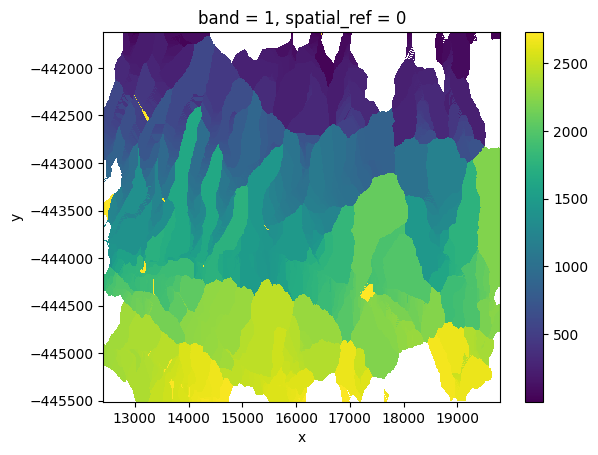

In [122]:
# subbasins
params = {
    'd8_pntr': d8_pntr_file,
    'streams': stream_raster_file, 
    'output': os.path.join(working_directory, "basins.tif"), 
    'esri_pntr': False, 
    'callback': my_callback
}
basins = wb_wrapper(wbt.subbasins, params, return_file=False)
basins.where(basins != -32768).plot()

In [128]:
# hillslopes

In [129]:
# snap pour points
# watershed

In [130]:
# ElevationAboveStream